In [1]:
import zipfile
from urllib import request
import imutils
import matplotlib.image as mpimg
import random
%matplotlib inline
import cv2
from glob import glob
import keras,math
import cv2 as cv 
import pandas as pd
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Reshape ,MaxPooling2D, advanced_activations
from keras.layers import concatenate, Concatenate,Dense, Flatten,SeparableConv2D,LeakyReLU,GlobalAveragePooling2D
from keras.layers import BatchNormalization, RepeatVector, Permute, Activation, Reshape, Flatten,Multiply
from keras.layers.advanced_activations import PReLU

from keras.layers import Lambda,Add,Dropout,SpatialDropout2D,DepthwiseConv2D,normalization
from keras.models import Sequential, Model 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.backend import clear_session
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.layers import MaxPooling2D, Input, Dense, Flatten
import numpy as np
from PIL import Image
import os
from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.gridspec as gridspec
 
import tensorflow as tf 
import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
 
# aita die akta tensor e sob image k nie astasi
 
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,merge,add
#from SpectralNormalizationKeras import DenseSN, ConvSN2D

from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,merge,add
#from SpectralNormalizationKeras import DenseSN, ConvSN2D

 
 
from keras.optimizers import Adam 

Using TensorFlow backend.


# Dataset loading

In [2]:
x_train = np.load('train_im.npy')
y_train = np.load('train_lb.npy')
x_test = np.load('test_im.npy')

re=list()

for i in range(len(y_train)):
    a=y_train[i]
    b=np.expand_dims(a, axis = 2)
    re.append(b)


re=np.asarray(re)
x_label=re 

print(x_train.shape, x_label.shape)
print(x_test.shape )


(670, 128, 128, 3) (670, 128, 128, 1)
(65, 128, 128, 3)


In [3]:
 
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())
 
def plot_sample(lr, sr):
    plt.figure(figsize=(10, 8))

    images = [lr, sr]
    titles = ['recovered map', 'input image']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img,cmap='gray')
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
def imgps(x):
    p = x[0] * 255
    p = p.astype(np.uint8)
    p = Image.fromarray(p)
    return p

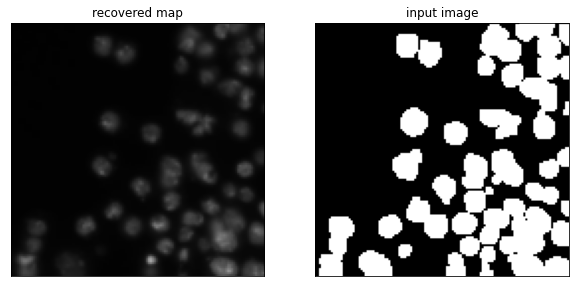

In [4]:
ind=6
a=x_train[ind] 
b=x_label[ind]
b=np.squeeze(b)
plot_sample(a,b)

In [5]:

def swishc(x):
    #x=BatchNormalization()(x)
    x1 = Activation('relu')(x)
    x2 = Activation('sigmoid')(x)
    y = Lambda(lambda x: x[0]*x[1])([x2,x])
    y=Conv2D(3, kernel_size=3, strides=1, padding='same', kernel_initializer = 'he_normal')(y)
    return y

def unt2(ip,f):
  
    conv1 = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ip)
    conv1 = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    
    conv2 = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    
    conv3 = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    
    conv4 = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    

    conv5 = Conv2D( f*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(f*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    
    u5=Conv2DTranspose(f, 3, strides=16,activation='relu', padding='same')(drop5)
    u4=Conv2DTranspose(f, 3, strides=8,activation='relu', padding='same')(pool3)
    u3=Conv2DTranspose(f, 3, strides=4,activation='relu', padding='same')(pool2)
    u2=Conv2DTranspose(f, 3, strides=2,activation='relu', padding='same')(pool1)
    u1=Conv2DTranspose(f, 3, strides=1,activation='relu', padding='same')(ip)
    
    s=concatenate([u1,u2,u3,u4,u5], axis = 3)
    s=swishc(s)
    col = concatenate([u1,u2,u3,u4,u5,s], axis = 3)
    col = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(col)
    ip = Conv2D(3, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ip)
    
    sm = add([col,ip])

 
    x = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(sm)
        
 
    return x


 
 

In [6]:
w=128
input_img = Input(shape=(w,w,3))
x1=unt2(input_img,40)
 
x = Conv2D(1, (1,1), activation ='sigmoid', padding = 'same', kernel_initializer = 'glorot_normal')(x1)

 
 

model = Model(input_img, x)

In [7]:
model.compile(optimizer = Adam(lr=2e-4) ,
                          loss = 'binary_crossentropy', metrics = [dice_coef])

In [8]:
 

filepath="B_seg2.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=False, 
                             mode='min')

In [9]:
model.fit(x_train, x_label, validation_split = .2, epochs = 70000, batch_size = 8, shuffle =  True, callbacks =  [checkpoint ])

Train on 536 samples, validate on 134 samples
Epoch 1/70000
536/536 [==============================] - 10s 18ms/step - loss: 1.0046 - dice_coef: 0.2867 - val_loss: 0.6893 - val_dice_coef: 0.2730

Epoch 00001: saving model to B_seg2.hdf5
Epoch 2/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.7856 - dice_coef: 0.2822 - val_loss: 0.6842 - val_dice_coef: 0.2725

Epoch 00002: saving model to B_seg2.hdf5
Epoch 3/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.7751 - dice_coef: 0.2824 - val_loss: 0.6793 - val_dice_coef: 0.2720

Epoch 00003: saving model to B_seg2.hdf5
Epoch 4/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.7656 - dice_coef: 0.2826 - val_loss: 0.6745 - val_dice_coef: 0.2716

Epoch 00004: saving model to B_seg2.hdf5
Epoch 5/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.7560 - dice_coef: 0.2820 - val_loss: 0.6697 - val_dice_coef: 0.2713

Epoch 00005: saving model to B_seg2.hdf5
Epo


Epoch 00043: saving model to B_seg2.hdf5
Epoch 44/70000
536/536 [==============================] - 5s 10ms/step - loss: 0.0980 - dice_coef: 0.8602 - val_loss: 0.0832 - val_dice_coef: 0.8618

Epoch 00044: saving model to B_seg2.hdf5
Epoch 45/70000
536/536 [==============================] - 5s 10ms/step - loss: 0.0965 - dice_coef: 0.8618 - val_loss: 0.0835 - val_dice_coef: 0.8691

Epoch 00045: saving model to B_seg2.hdf5
Epoch 46/70000
536/536 [==============================] - 5s 10ms/step - loss: 0.0950 - dice_coef: 0.8622 - val_loss: 0.0818 - val_dice_coef: 0.8609

Epoch 00046: saving model to B_seg2.hdf5
Epoch 47/70000
536/536 [==============================] - 5s 10ms/step - loss: 0.0939 - dice_coef: 0.8633 - val_loss: 0.0821 - val_dice_coef: 0.8765

Epoch 00047: saving model to B_seg2.hdf5
Epoch 48/70000
536/536 [==============================] - 5s 10ms/step - loss: 0.0920 - dice_coef: 0.8653 - val_loss: 0.0892 - val_dice_coef: 0.8758

Epoch 00048: saving model to B_seg2.hdf5
Epo


Epoch 00086: saving model to B_seg2.hdf5
Epoch 87/70000
536/536 [==============================] - 5s 10ms/step - loss: 0.0649 - dice_coef: 0.9046 - val_loss: 0.0771 - val_dice_coef: 0.8975

Epoch 00087: saving model to B_seg2.hdf5
Epoch 88/70000
536/536 [==============================] - 5s 10ms/step - loss: 0.0647 - dice_coef: 0.9041 - val_loss: 0.0738 - val_dice_coef: 0.8978

Epoch 00088: saving model to B_seg2.hdf5
Epoch 89/70000
536/536 [==============================] - 5s 10ms/step - loss: 0.0666 - dice_coef: 0.9020 - val_loss: 0.0743 - val_dice_coef: 0.8990

Epoch 00089: saving model to B_seg2.hdf5
Epoch 90/70000
536/536 [==============================] - 5s 10ms/step - loss: 0.0647 - dice_coef: 0.9043 - val_loss: 0.0690 - val_dice_coef: 0.9018

Epoch 00090: saving model to B_seg2.hdf5
Epoch 91/70000
536/536 [==============================] - 5s 10ms/step - loss: 0.0625 - dice_coef: 0.9077 - val_loss: 0.0691 - val_dice_coef: 0.9022

Epoch 00091: saving model to B_seg2.hdf5
Epo

536/536 [==============================] - 5s 10ms/step - loss: 0.0424 - dice_coef: 0.9363 - val_loss: 0.0826 - val_dice_coef: 0.9129

Epoch 00129: saving model to B_seg2.hdf5
Epoch 130/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.0458 - dice_coef: 0.9316 - val_loss: 0.0841 - val_dice_coef: 0.9056

Epoch 00130: saving model to B_seg2.hdf5
Epoch 131/70000
536/536 [==============================] - 5s 10ms/step - loss: 0.0452 - dice_coef: 0.9322 - val_loss: 0.0804 - val_dice_coef: 0.9136

Epoch 00131: saving model to B_seg2.hdf5
Epoch 132/70000
536/536 [==============================] - 5s 10ms/step - loss: 0.0417 - dice_coef: 0.9374 - val_loss: 0.0782 - val_dice_coef: 0.9143

Epoch 00132: saving model to B_seg2.hdf5
Epoch 133/70000
536/536 [==============================] - 5s 10ms/step - loss: 0.0416 - dice_coef: 0.9377 - val_loss: 0.0858 - val_dice_coef: 0.9099

Epoch 00133: saving model to B_seg2.hdf5
Epoch 134/70000
536/536 [==============================]


Epoch 00171: saving model to B_seg2.hdf5
Epoch 172/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.0274 - dice_coef: 0.9583 - val_loss: 0.1032 - val_dice_coef: 0.9176

Epoch 00172: saving model to B_seg2.hdf5
Epoch 173/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.0286 - dice_coef: 0.9567 - val_loss: 0.1030 - val_dice_coef: 0.9169

Epoch 00173: saving model to B_seg2.hdf5
Epoch 174/70000
536/536 [==============================] - 5s 10ms/step - loss: 0.0270 - dice_coef: 0.9593 - val_loss: 0.1033 - val_dice_coef: 0.9177

Epoch 00174: saving model to B_seg2.hdf5
Epoch 175/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.0265 - dice_coef: 0.9598 - val_loss: 0.1046 - val_dice_coef: 0.9182

Epoch 00175: saving model to B_seg2.hdf5
Epoch 176/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.0266 - dice_coef: 0.9596 - val_loss: 0.1035 - val_dice_coef: 0.9183

Epoch 00176: saving model to B_seg2.hdf

536/536 [==============================] - 6s 10ms/step - loss: 0.0201 - dice_coef: 0.9693 - val_loss: 0.1308 - val_dice_coef: 0.9178

Epoch 00214: saving model to B_seg2.hdf5
Epoch 215/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.0195 - dice_coef: 0.9702 - val_loss: 0.1283 - val_dice_coef: 0.9197

Epoch 00215: saving model to B_seg2.hdf5
Epoch 216/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.0191 - dice_coef: 0.9710 - val_loss: 0.1298 - val_dice_coef: 0.9195

Epoch 00216: saving model to B_seg2.hdf5
Epoch 217/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.0188 - dice_coef: 0.9713 - val_loss: 0.1301 - val_dice_coef: 0.9202

Epoch 00217: saving model to B_seg2.hdf5
Epoch 218/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.0210 - dice_coef: 0.9686 - val_loss: 0.1324 - val_dice_coef: 0.9195

Epoch 00218: saving model to B_seg2.hdf5
Epoch 219/70000
536/536 [==============================]


Epoch 00256: saving model to B_seg2.hdf5
Epoch 257/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.0158 - dice_coef: 0.9764 - val_loss: 0.1526 - val_dice_coef: 0.9206

Epoch 00257: saving model to B_seg2.hdf5
Epoch 258/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.0158 - dice_coef: 0.9762 - val_loss: 0.1653 - val_dice_coef: 0.9193

Epoch 00258: saving model to B_seg2.hdf5
Epoch 259/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.0145 - dice_coef: 0.9779 - val_loss: 0.1591 - val_dice_coef: 0.9210

Epoch 00259: saving model to B_seg2.hdf5
Epoch 260/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.0160 - dice_coef: 0.9765 - val_loss: 0.1515 - val_dice_coef: 0.9153

Epoch 00260: saving model to B_seg2.hdf5
Epoch 261/70000
536/536 [==============================] - 6s 10ms/step - loss: 0.0224 - dice_coef: 0.9688 - val_loss: 0.1451 - val_dice_coef: 0.9201

Epoch 00261: saving model to B_seg2.hdf

KeyboardInterrupt: 

In [10]:
model.save('B_seg2.h5')   


## Testing

In [11]:
val=x_test

In [12]:
val.shape

(65, 128, 128, 3)

In [13]:
model.load_weights('B_seg2.h5')
per =  model.predict(val)
 

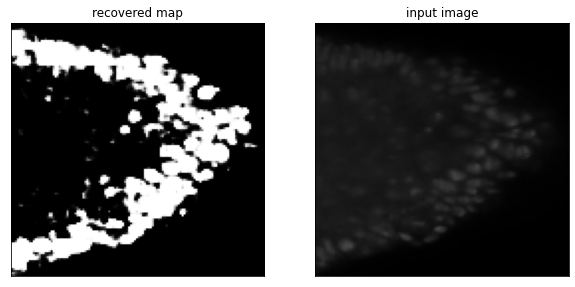

In [20]:
i=26
 
p=per[i]  
p= np.squeeze(p)
p=p.astype('float32')
 
q=val[i]
plot_sample( p,q)